<a href="https://colab.research.google.com/github/naimaryan1/Smoke_Fire_Detection_On_Edge_Devices/blob/main/PUBLIC_yolov8_fire_and_smoke_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Complete training pipeline to train YOLOv8 classifier for fire & smoke detection based on images.**


**Motivation:** In recent years, early fire detection has become vital due to large-scale fires causing extensive financial damage and loss of life in such places as the United States, Canada, and Europe. This intercative coding environment introduces how to train deep neural networks for detecting fire and smoke, leveraging the inference of high-speed YOLO architecture. YOLO can be optimized for deployment on resource-limited edge hardware like the Raspberry Pi. The tutorial covers the entire process, including data preprocessing, model training, hyperparameter tuning, evaluating model metrics, and conducting model inference in a cloud environment.

**Step 1:**

Since we are going to run long running tasks we need a way to keep Google Collab alive even after hours of running. Even if you sign for Google Collab’s “professional” version the browser will timeout after ~30 min of inactivity.

Do this hack to keep your browser alive:
https://www.codeease.net/programming/javascript/keep-colab-from-disconnecting



In [2]:
"""
Complete training pipeline to train YOLOv8 classifier for fire & smoke detecction based on images.

Developer: Ary Naim (anaim@unm.edu)

Advisor: Dr. Marios Pattichis (pattichi@unm.edu)

Github:https://github.com/naimaryan1/Smoke_Fire_Detection_On_Edge_Devices
For The class MyFireSmokeDataset from my_fire_smoke_dataset.py refer to zip
folder in Github titled: GeneratorBasedBuilder_my_fire_smoke_dataset.zip

References:

1) Implementation was heavily based on:                         https://keras.io/examples/vision/yolov8/
2) Adding custom dataset via tensorflow:                        https://www.tensorflow.org/datasets/add_dataset
3) Dataset->                                                    https://github.com/gaiasd/DFireDataset
4) Attemptiong to reproduce this paper however using YOLOv8:
                                                                https://link.springer.com/article/10.1007/s00521-023-08260-2
                                                                https://www.researchgate.net/publication/361649776_An_automatic_fire_detection_system_based_on_deep_convolutional_neural_networks_for_low-power_resource-constrained_devices#fullTextFileContent

Status: Since YOLOv8 is relatively new & there are ongoing issues & improvments this is a live document.

Known Issues related Keras's implementation of YOLOv8:
1) https://github.com/keras-team/keras-cv/issues/2095
2) https://github.com/keras-team/keras-cv/issues/2442
3) KERAS YOLOv8 DOEST traditional metrics: https://github.com/keras-team/keras/issues/19416

WARNING: After running the experiment or any development change the runtime to CPU or "Disconnect & delete runtime" or
you will be billed per hour by Google.

WARNING: No Warranties. The author makes no warranties, express or implied, with respect to code. Use at your own risk.

"""

#PLEASE READ & EXECUTE STEP BY STEP.
""" STEP 1) To avoid reconnects read: https://www.codeease.net/programming/javascript/keep-colab-from-disconnecting
"""

""" Step 2) Installation steps"""
#installations - START
!pip install tensorflow==2.15.0  # Upgrade to TensorFlow 2.  # Remove Keras 2.
!pip install keras==2.15.0  # Upgrade to Keras 2.
!pip install keras-cv
!pip install h5py
!pip install matplotlib
#installations - END

**Mount your Google Drive**


In [3]:
""" Step 3) Mount Drive"""
#MOUNT DRIVE - START
from google.colab import drive
drive.mount('/content/gdrive')
#link your path to create a symbolic link
!ln -s /content/gdrive/My\ Drive/ /mydrive
#MOUNT DRIVE - END


Mounted at /content/gdrive


***Step 4: Import the required libraries***

In [4]:
""" Step 4) Mount imports"""
#imports - START
import os
import sys
sys.path.append('.')
sys.path.append('..')
sys.path.append('/content/gdrive/MyDrive/my_fire_smoke_dataset') #You & can should have this to refer to the location for your custom dataset
#import custom dataset
from my_fire_smoke_dataset import MyFireSmokeDataset
os.environ["KERAS_BACKEND"] = "tensorflow"  # @param ["tensorflow", "jax", "torch"]
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import tensorflow as tf
print("TF VERSION:",tf.__version__)
import keras
print("Keras VERSION:",keras.__version__)
import keras_cv
import numpy as np
from keras_cv import bounding_box
from keras_cv import visualization
import tqdm
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import label_binarize
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import random
from sklearn.model_selection import train_test_split
keras.backend.clear_session()
keras.backend.set_floatx("float32")
#imports - END

TF VERSION: 2.15.0
Keras VERSION: 2.15.0
Using TensorFlow backend


**Optional - Step 5) Add dataset to Keras**

**IMPORTANT:**

**If** you are using a precanned dataset from Keras OR you just want to run this Notbobook as is, you can skip this step #5 & go to step 6.

**Else** if you have custom dataset you have to follow this guide (https://www.tensorflow.org/datasets/add_dataset) along with our detailed instructions in the Word doc titled "Guide"

*   Before proceeding and makesure the command "tfds build --register_checksums" returns no errors.

**step 6) Declare variables & functions**

In [7]:

"""step 6) declare variables & functions"""

#VARIABLES.
#IMPORTANT: change the labels here to reflect the actual labels you have based on your dataset.
class_ids = [
    "Fire",
     "Smoke",
]

"""We are only using this tuple image_size_1.
The YOLO sizes can be multiples of 32. Such as (320,320)"""
image_size_1 = (640,640)

class_mapping = dict(zip(range(len(class_ids)), class_ids))


# FUNCTION DECLARATIONS - START
"""
visualize the image data before preprocessing.
"""
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    #inputs = inputs[1]
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=None,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )

"""
Just return  {"images": image, "bounding_boxes": bounding_boxes} to conform
to unpack_input() in yolo_v8_detector.py. This actually causes major limitations.
"""
def unpackage_raw_tfds_inputs(inputs, bounding_box_format):
    image = inputs["image"]
    boxes = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="rel_yxyx",
        target=bounding_box_format,
    )
    bounding_boxes = {
        "classes": inputs["objects"]["label"],
        "boxes": boxes,
    }
    return {"images": image, "bounding_boxes": bounding_boxes}


def load_pascal_voc(split, dataset, bounding_box_format):
    ds = tfds.load(dataset, split=split, with_info=False, shuffle_files=True)
    ds = ds.map(
        lambda x: unpackage_raw_tfds_inputs(x, bounding_box_format=bounding_box_format),
        num_parallel_calls=tf_data.AUTOTUNE,
    )
    return ds

#Example of getting custom data. Refer to:https://www.tensorflow.org/datasets/add_datase
def get_data_train_ds_my_fire_smoke():
  train_ds = load_pascal_voc(split="train", dataset="my_fire_smoke_dataset", bounding_box_format="xyxy")
  return train_ds

#Example of getting custom data. Refer to: https://www.tensorflow.org/datasets/add_datase
def get_data_eval_ds_my_fire_smoke():
  eval_ds = load_pascal_voc(split="test", dataset="my_fire_smoke_dataset", bounding_box_format="xyxy")
  return eval_ds

"""
This get_data_train_ds() is NO being used its just an example of getting prepackaged data.
This is good for learning the API without have to worry about preprocessing.

def get_data_train_ds():
  train_ds = load_pascal_voc(split="train", dataset="voc/2007", bounding_box_format="xyxy")
  return train_ds

#Example of getting prepackaged data. This is good for learning.
def get_data_eval_ds():
  eval_ds = load_pascal_voc(split="test", dataset="voc/2007", bounding_box_format="xyxy")
  return eval_ds

"""

"""
Calls preprocessors on the data.
"""
def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs
    return augmenter_fn
#Data augmentation - END

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )

"""vislualize the predictions"""
def visualize_predictions(images, y_true, y_pred, bounding_box_format):
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

"""vislualize the detections similar to visualize_predictions()"""
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )

def shuffle_generator(image, bounding,label, seed):
    idx = np.arange(len(image))
    np.random.default_rng(seed).shuffle(idx)
    for i in idx:
        yield image[i],bounding[i],label[i]

"""TODO:
visualize_ground_truth()
Utimately we want to compare the predictions y_pred vs y_true (from actual label files not preprocessed in any way).
The issue is https://github.com/keras-team/keras-cv/blob/v0.9.0/keras_cv/src/models/object_detection/yolo_v8/yolo_v8_detector.py
which uses unpack_inputto return only a subset of the original data attributes. We want to be able to return 'image', image/filename'
objects={'label','bbox'} however we are only given 'image' and 'bbox' and 'bbox' has already been converted from YOLO x,y,w,h to xyxy.
In order to achieve this yolo_v8_detector.py will need to be significantly modified.
"""
def visualize_ground_truth(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    #inputs = inputs[1]
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    print("type(images):",type(images))
    print("images[0]:",images[0])
    label_path = "/content/gdrive/MyDrive/Smoke_and_Fire_Datasets/D-Fire/train/labels/"
    # Change the image path to the corresponding label path
    label_file = label_path.replace('/images', '/labels').replace('.jpg', '.txt')
    original_bbox = self.read_bounding_box(label_file)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=original_bbox,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


# FUNCTION DECLARATIONS - END


**step 7) Start the experiment & load data**

Noe that we have imported all the required imports and declared all the required functions. Lets run the experiment.

**YOU NEED A RUNTIME WITH A GPU.** Makesure to switch the runtime to a GPU that you can afford (start with L4). You may need re-run previous steps as the runtime is restarted.

You should start seeing the dataset being loaded. This will take a while even though we are only using 500 images which is not enough for building an accurate model.

*Note:* If you want to load the entire 20,000 images open the Python file title “my_fire_smoke_dataset.py” and make an update in the function.

GET DATA - START 
GET DATA - END
#PREPROCESS - START
AUGMENTATION - START
RESIZING - START
TRAINING - START
Model: "yolov8_detector_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_5 (Functional)        {'P3': (None, None, None,    1187246   ['input_12[0][0]']            
                             192),                        4                                       
                              'P4': (None, None, None,                                            
                             384),                                                                
                              'P5': (None, None, None,                   

97/97 [==============================] - 13s 105ms/step
creating index...
index created!
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.00s).
Accumulating evaluation results...
Please run evaluate() first
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]

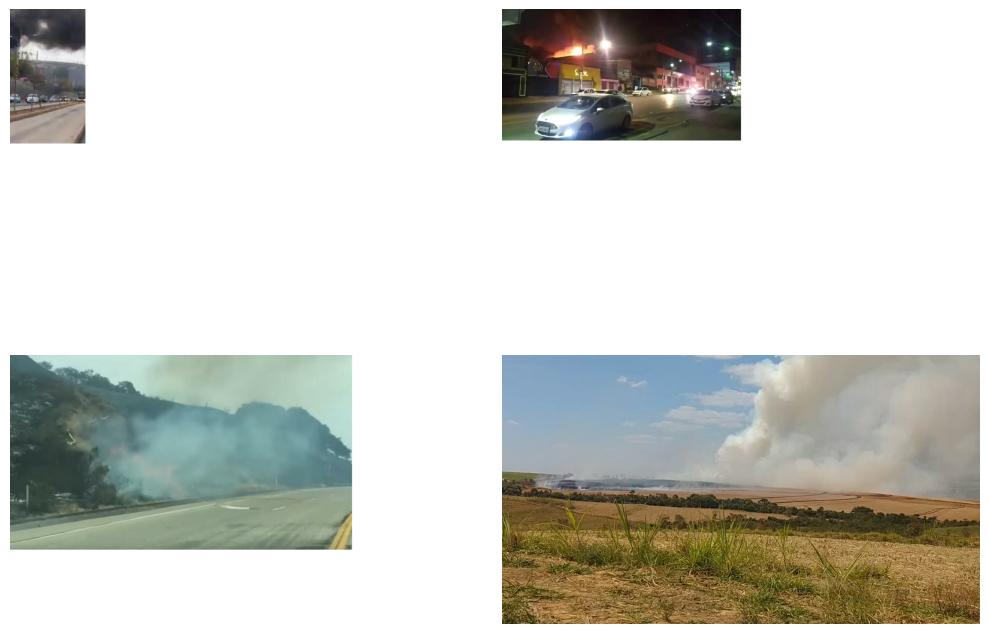

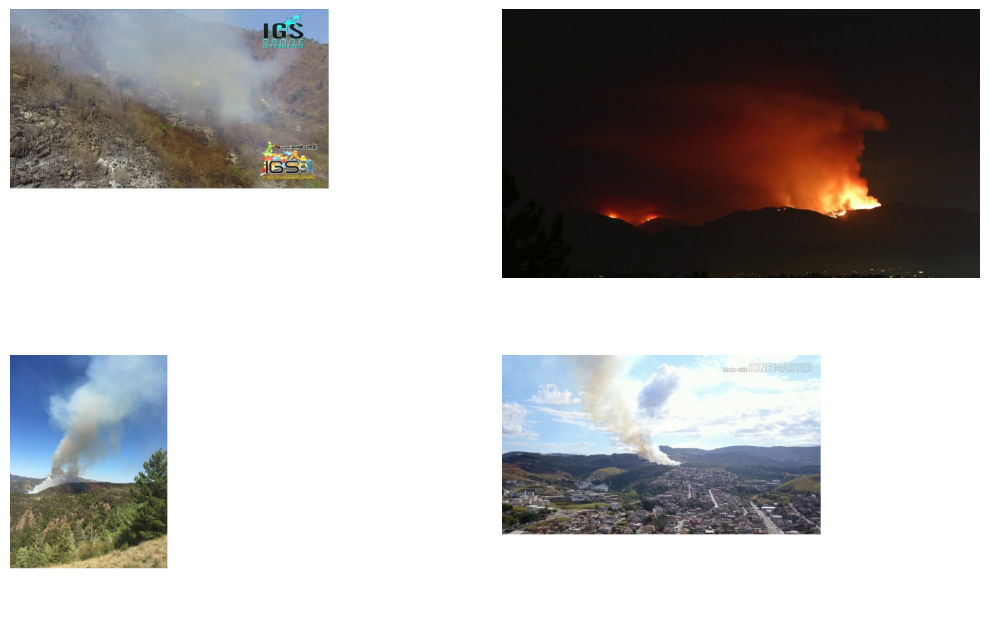

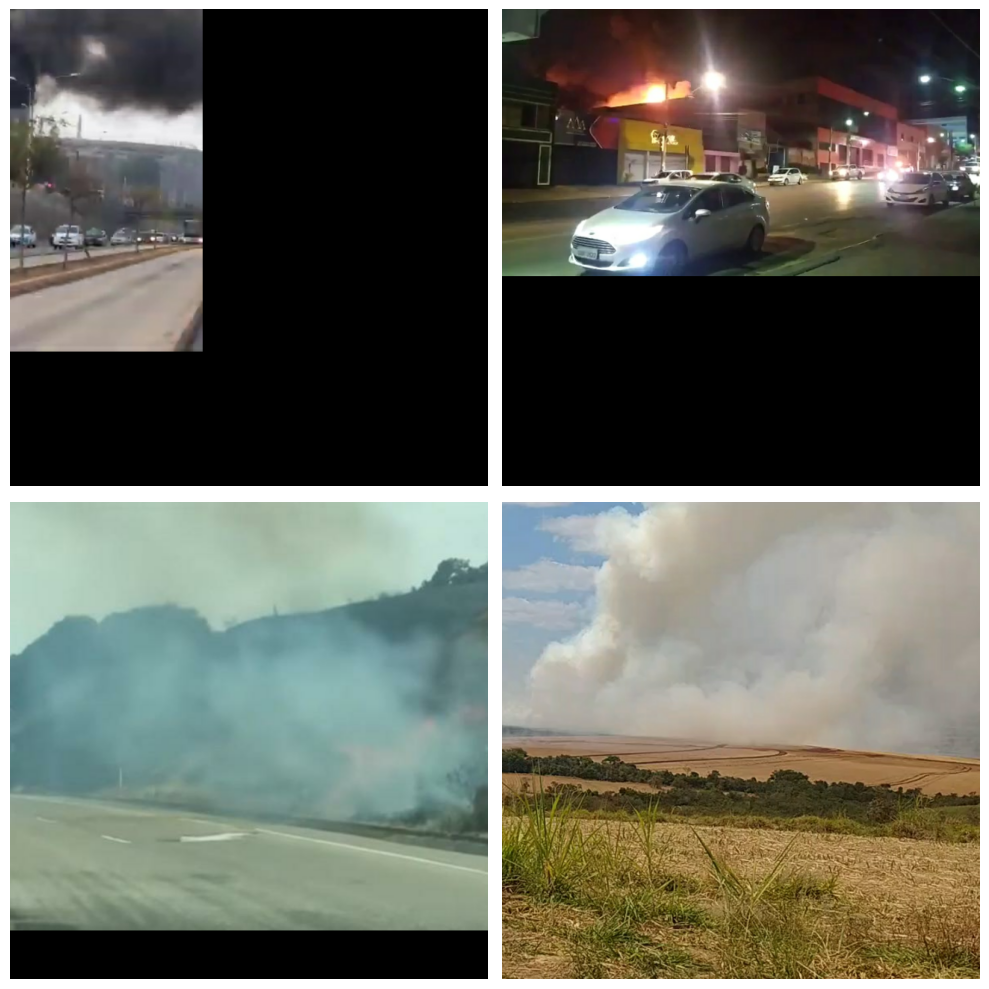

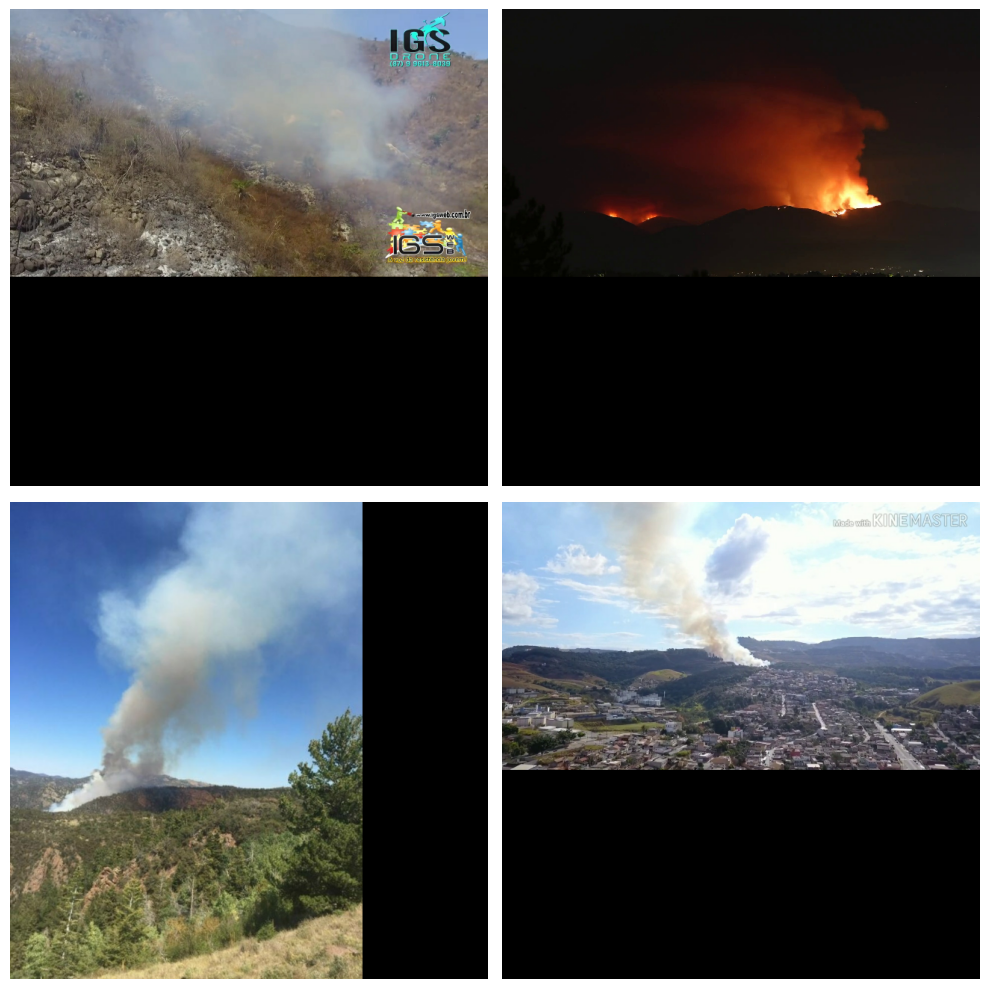

In [17]:
"""step 7) Start the experiment & load data"""
#PARAMATERS
#hyperparameters - START
BATCH_SIZE = 4
LEARNING_RATE = 0.005  #try 0.001 to 0.005
EPOCHS = 50 # 50 epochs is not enough, the original paper ran epoches frpm 5,000 to 30,000
MOMENTUM = 0.9
#hyperparameters - END

#GET DATA
print("GET DATA - START ")
#custom data
train_ds = get_data_train_ds_my_fire_smoke()
eval_ds = get_data_eval_ds_my_fire_smoke()
# train_ds = get_data_train_ds()
# eval_ds = get_data_eval_ds()
print("GET DATA - END")

#PREPROCESS - START
print("#PREPROCESS - START")
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
#VISUALIZATION - optional
visualize_dataset(train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)
visualize_dataset(
      eval_ds,
      bounding_box_format="xyxy",
      value_range=(0, 255),
      rows=2,
      cols=2,
      # If you are not running your experiment on a local machine, you can also
      # make `visualize_dataset()` dump the plot to a file using `path`:
      # path="eval.png"
  )

print("AUGMENTATION - START")
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
    keras_cv.layers.JitteredResize(
        target_size=image_size_1, scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
    ),
]
augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

inference_resizing = keras_cv.layers.Resizing(
   image_size_1[0],image_size_1[1], bounding_box_format="xyxy", pad_to_aspect_ratio=True
)
print("RESIZING - START")
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf_data.AUTOTUNE)
visualize_dataset(eval_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)
#In order to be TPU compatible, bounding box Tensors need to be Dense instead of Ragged.
train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)
eval_ds = eval_ds.map(dict_to_tuple, num_parallel_calls=tf_data.AUTOTUNE)

train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf_data.AUTOTUNE)
print("#PREPROCESS - END")
#PREPROCESS - END

#OPTIMIZER - START
# including a global_clipnorm is extremely important in object detection tasks
optimizer = keras.optimizers.SGD(
    learning_rate=LEARNING_RATE, momentum=MOMENTUM, global_clipnorm=10.0
)
#OPTIMIZER - END


#LOSS FUNCTION - START
# The following NonMaxSuppression layer is equivalent to disabling the operation
prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0,
)
#LOSS FUNCTION - END

#DEFINE MODEL
#YOLOv8, references: https://keras.io/api/keras_cv/models/backbones/yolo_v8/
#A medium YOLOV8 backbone pretrained on COCO
model = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_ids),
    bounding_box_format="xyxy",
    backbone=keras_cv.models.YOLOV8Backbone.from_preset(
        "yolo_v8_m_backbone_coco"
    ),
    fpn_depth=2
)

#TRAINING - START
#the KerasCV API to construct an untrained YOLOV8Detector model
print("TRAINING - START")

model.compile(
    classification_loss="binary_crossentropy",
    box_loss="ciou",
    optimizer=optimizer,
)

model.summary()

#METRICS CALL BACK
metrics_callback = keras_cv.callbacks.PyCOCOCallback(
    eval_ds, bounding_box_format="xyxy"
)

model.fit(
    train_ds,
    # Run for 10-35~ epochs to achieve good scores.
    epochs=EPOCHS,
    callbacks=[metrics_callback],
)

#Save the model to disk to avoid having to rebuild everytime you want to use the model
model_path = F"/content/gdrive/My Drive/ece551/week2_model/YOLOV8_model.keras"
model.save(model_path)
print("TRAINING - END")

**Step 8 Inference - Lets load & use the model**

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/task.py:43: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model loaded from disk
1/1 [==============================] - 3s 3s/step
VISUALIZE PREDICTION - START


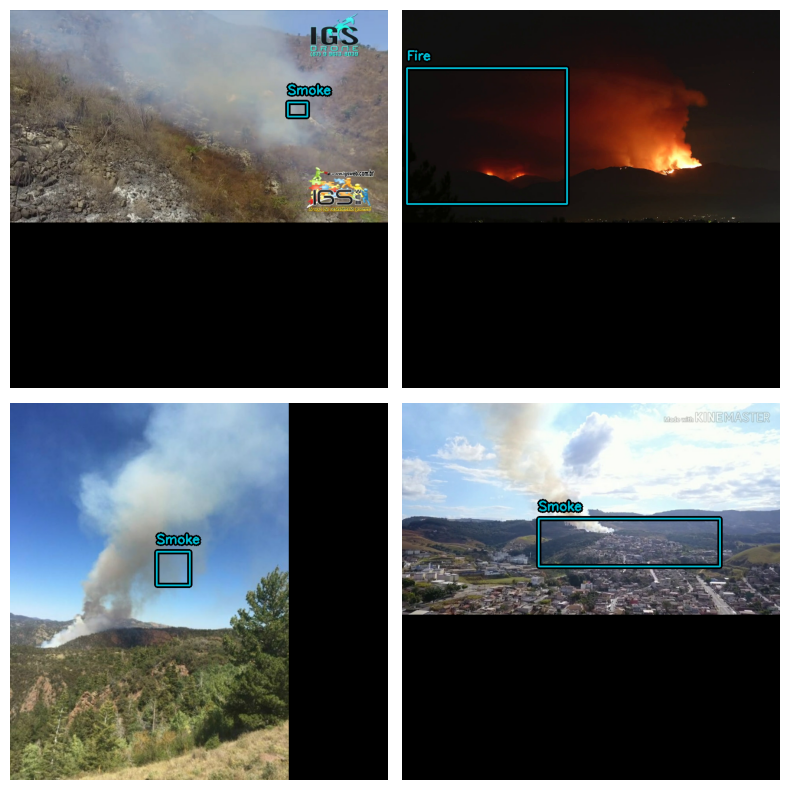

VISUALIZE PREDICTION - END
Model: "yolov8_detector_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_12 (InputLayer)       [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_5 (Functional)        {'P3': (None, None, None,    1187246   ['input_12[0][0]']            
                             192),                        4                                       
                              'P4': (None, None, None,                                            
                             384),                                                                
                              'P5': (None, None, None,                                            
                             576)}                     

In [21]:
#INFERENCE - Lets use the mode
#load previously built model from disk to avoid having to retrain everytime you want to use the model
model_path = F"/content/gdrive/My Drive/ece551/week2_model/YOLOV8_model.keras"
loaded_model = keras.saving.load_model(model_path)
model = loaded_model
if model is not None:
    print("Model loaded from disk")
else:
    print("Failed to load model from disk")

if model is not None:
    model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

#LOAD MODEL - END
#INFERENCE
visualization_ds = eval_ds.unbatch()
visualization_ds = visualization_ds.ragged_batch(16)
images, y_true = next(iter(visualization_ds.take(1)))
y_pred = model.predict(images)

#VISUALIZE PREDICTION
print("VISUALIZE PREDICTION - START")
visualize_predictions(images, y_true, y_pred,bounding_box_format="xyxy")
print("VISUALIZE PREDICTION - END")

model.prediction_decoder = keras_cv.layers.NonMaxSuppression(
    bounding_box_format="xyxy",
    from_logits=True,
    iou_threshold=0.5,
    confidence_threshold=0.75,
)

#METRICS CALL BACK
print(metrics_callback.model.summary())

# **This is work in progress.**

**There are known issues with Keras's implementation:**

1) https://github.com/keras-team/keras-cv/issues/2095

Standard reported metrics such as UoI, Precision, Recall, and F1-score are not being reported back.

Similar issue: https://github.com/keras-team/keras/issues/19416

2) https://github.com/keras-team/keras-cv/issues/2442

Bad performance when compared to Ultralytics. This is probably due to problem #1 as we have no standard metrics to tune the experinment.

3) Transfer learning - Furthermore, we should try freezing the layers and comparing the performnance when issues #1 & #2 are fixed by Keras.